Training Configuration:
{'file_path': '/kaggle/input/kgfb-sim-fr-jan04/kgfb_sim_fr_jan04.xlsx', 'a': 1.5, 'plateau_threshold': 1, 'max_depth': 3, 'eta': 0.1, 'nrounds': 500, 'nthread': 2}
[0]	train-rmse:1.81915	eval-rmse:0.32224
[10]	train-rmse:0.75533	eval-rmse:1.40056
[20]	train-rmse:0.48575	eval-rmse:1.79518
[30]	train-rmse:0.44065	eval-rmse:1.93286
[40]	train-rmse:0.43388	eval-rmse:1.98046
[50]	train-rmse:0.43189	eval-rmse:1.99700


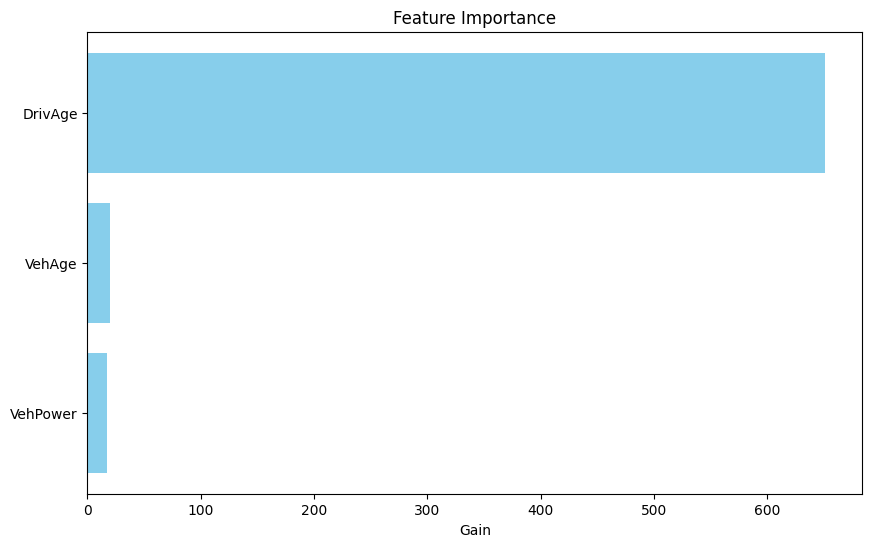

Validation AUC: 0.5166


In [10]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Configurable parameters
config = {
    "file_path": "/kaggle/input/kgfb-sim-fr-jan04/kgfb_sim_fr_jan04.xlsx",
    "a": 1.5,
    "plateau_threshold": 1,
    "max_depth": 3,
    "eta": 0.1,
    "nrounds": 500,
    "nthread": 2,
}

print("Training Configuration:")
print(config)

# Load data
data = pd.read_excel(config["file_path"])

# Prepare the variables
A = data["A"]
T = data["T"]
V = data["V"]
features = data[["VehPower", "VehAge", "DrivAge"]]

# Create custom objective
def custom_objective_factory(a, plateau_threshold):
    def custom_objective(preds, dtrain):
        y_true = dtrain.get_label()
        your_prices = dtrain.get_weight()
        market_prices = dtrain.get_base_margin()

        # Sigmoid probabilities
        probs = 1 / (1 + np.exp(-preds))
        grad = probs - y_true
        hess = probs * (1 - probs)

        # Deviation and weights
        deviation = your_prices - market_prices
        adjusted_deviation = np.clip(deviation, 0, plateau_threshold)  # Ensure non-negative and capped

        weights = np.where(
            adjusted_deviation > 0,
            adjusted_deviation ** (a - 1) * np.exp(-adjusted_deviation),
            1
        )

        # Avoid NaN or inf values in grad/hess
        weights = np.nan_to_num(weights, nan=1.0, posinf=1.0, neginf=1.0)
        grad *= weights
        hess *= weights
        return grad, hess

    return custom_objective




# Split data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=123)

# Adjust weights to be strictly positive
train_data["V"] += abs(min(train_data["V"])) + 1e-6

# Prepare datasets
dtrain = xgb.DMatrix(
    data=train_data[["VehPower", "VehAge", "DrivAge"]],
    label=train_data["A"],
    weight=train_data["V"],
    base_margin=train_data["T"],
)
dval = xgb.DMatrix(
    data=val_data[["VehPower", "VehAge", "DrivAge"]],
    label=val_data["A"],
)

params = {
    "max_depth": config["max_depth"],
    "eta": config["eta"],
    "nthread": config["nthread"],
}

obj = custom_objective_factory(config["a"], config["plateau_threshold"])

watchlist = [(dtrain, "train"), (dval, "eval")]

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=config["nrounds"],
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=10,
)

# Save the model
model.save_model("xgboost_model.json")

# Compute feature importance
importance = model.get_score(importance_type="gain")
importance_df = pd.DataFrame(list(importance.items()), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Gain")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.savefig("feature_importance.png")
plt.show()

# Evaluate on validation data
val_preds = model.predict(dval)
auc = roc_auc_score(val_data["A"], val_preds)
print(f"Validation AUC: {auc:.4f}")

# Save the tree structure
with open("tree_dump.txt", "w") as f:
    f.write("\n".join(model.get_dump(dump_format="text")))


<Figure size 2000x1000 with 0 Axes>

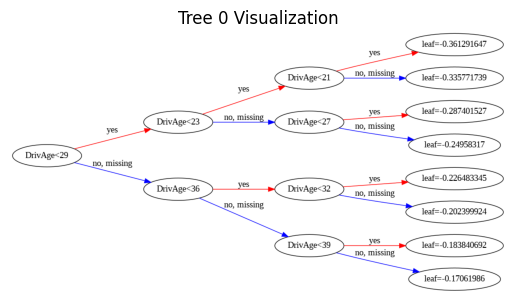

In [13]:
import matplotlib.pyplot as plt
from xgboost import plot_tree

# Plot the first tree in the model
plt.figure(figsize=(20, 10))  # Adjust figure size for better readability
plot_tree(model, num_trees=0, rankdir="LR")  # rankdir="LR" for horizontal layout
plt.title("Tree 0 Visualization")
plt.savefig("tree_graph.png")  # Save the plot as an image
plt.show()


<Figure size 2000x1000 with 0 Axes>

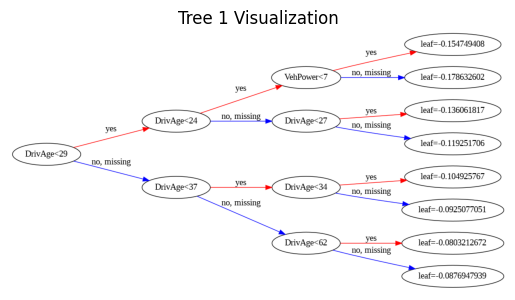

In [14]:
import matplotlib.pyplot as plt
from xgboost import plot_tree

# Plot the first tree in the model
plt.figure(figsize=(20, 10))  # Adjust figure size for better readability
plot_tree(model, num_trees=7, rankdir="LR")  # rankdir="LR" for horizontal layout
plt.title("Tree 1 Visualization")
plt.savefig("tree_graph.png")  # Save the plot as an image
plt.show()
